Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

## Importing Skin Cancer Data

## Importing all the important libraries


In [1]:
import os
import PIL
import pathlib

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from keras.callbacks import ReduceLROnPlateau
from keras.utils.np_utils import to_categorical
from tensorflow.keras.layers import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.python.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPool2D

In [2]:
data_dir_train = pathlib.Path("/home/rishabh/Documents/Diploma_notebook/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path('/home/rishabh/Documents/Diploma_notebook/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Test')


In [3]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


## Load using keras.preprocessing


### Let's load these images off disk using the helpful image_dataset_from_directory utility.



### Define some parameters for the loader:



In [4]:
batch_size = 32
img_height = 180
img_width = 180

### Use 90% of the images for training, and 10% for validation.

In [5]:
from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(validation_split=0.1)

In [6]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.1,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 2016 files for training.


In [7]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.1,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 2239 files belonging to 9 classes.
Using 223 files for validation.


In [8]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_test,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 118 files belonging to 9 classes.


In [14]:
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


## Visualize the data


### create a code to visualize one instance of all the nine classes present in the dataset


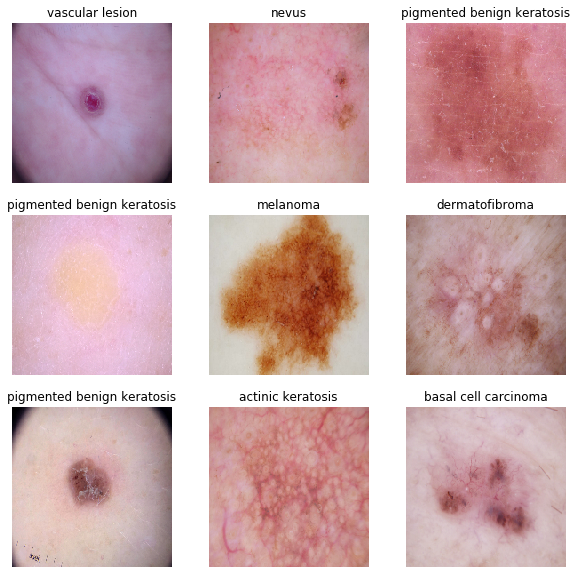

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

The image_batch is a tensor of the shape (32, 180, 180, 3). This is a batch of 32 images of shape 180x180x3 (the last dimension refers to color channels RGB). The label_batch is a tensor of the shape (32,), these are corresponding labels to the 32 images.

Dataset.cache() keeps the images in memory after they're loaded off disk during the first epoch.

Dataset.prefetch() overlaps data preprocessing and model execution while training.

## Model 1

In [24]:
preprocessing_layers = [
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180, 180, 3))
]

In [25]:
input_shape = (180,180,3)
lr = 1e-5
init = 'normal'
activ = 'relu'

model = Sequential()
model.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180, 180, 3)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

## Number of classes is 9
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_3 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
module_wrapper_14 (ModuleWra (None, 178, 178, 64)      1792      
_________________________________________________________________
module_wrapper_15 (ModuleWra (None, 89, 89, 64)        0         
_________________________________________________________________
module_wrapper_16 (ModuleWra (None, 87, 87, 32)        18464     
_________________________________________________________________
module_wrapper_17 (ModuleWra (None, 43, 43, 32)        0         
_________________________________________________________________
module_wrapper_18 (ModuleWra (None, 41, 41, 32)        9248      
_________________________________________________________________
batch_normalization_2 (Batch (None, 41, 41, 32)       

In [26]:
optimizer = 'adam'
loss_fn = "binary_crossentropy"
model.compile(optimizer=optimizer,
              loss=loss_fn,
              metrics=['accuracy'])

In [27]:
epochs = 20
batch_size = 32

history = model.fit(
  train_ds,
  batch_size=batch_size,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
63/63 [==============================] - 62s 929ms/step - loss: -17846.8418 - accuracy: 0.1682 - val_loss: -16525.8066 - val_accuracy: 0.1659
Epoch 2/20
63/63 [==============================] - 58s 910ms/step - loss: -211359.6719 - accuracy: 0.1682 - val_loss: -208346.2188 - val_accuracy: 0.1659
Epoch 3/20
63/63 [==============================] - 61s 920ms/step - loss: -793194.8750 - accuracy: 0.1682 - val_loss: -825398.3750 - val_accuracy: 0.1659
Epoch 4/20
63/63 [==============================] - 61s 917ms/step - loss: -1951225.3750 - accuracy: 0.1682 - val_loss: -2102880.7500 - val_accuracy: 0.1659
Epoch 5/20
63/63 [==============================] - 57s 883ms/step - loss: -3893436.2500 - accuracy: 0.1682 - val_loss: -3251057.7500 - val_accuracy: 0.1659
Epoch 6/20
63/63 [==============================] - 57s 889ms/step - loss: -6813764.0000 - accuracy: 0.1682 - val_loss: -6377716.0000 - val_accuracy: 0.1659
Epoch 7/20
63/63 [==============================] - 57s 892ms/step

### Visualizing training results

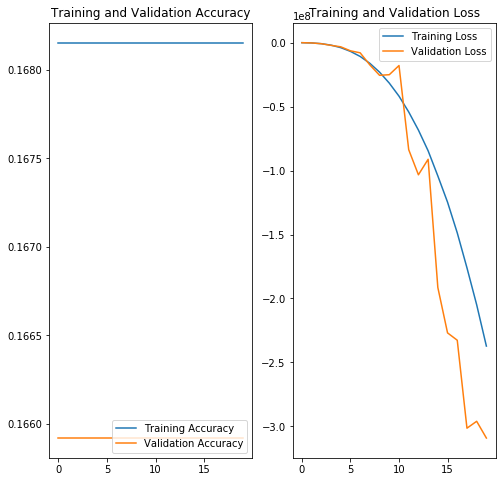

In [28]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']


epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


### Model 2

In [37]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

image_class = ['nevus','melanoma','basal_cell_caricoma','actinic_keratosis','vasc_lesion','dermatofibroma', 'pigmented_keratosis', 'seborrheic_keratosis', 'squamous_carci']

train_batches = datagen.flow_from_directory(data_dir_train, 
    target_size = (180,180),
    classes = image_class,
    batch_size = 64
 )

valid_batches = datagen.flow_from_directory(data_dir_test, 
    target_size = (180,180),
    classes = image_class,
    batch_size = 64
)

Found 890 images belonging to 9 classes.
Found 48 images belonging to 9 classes.


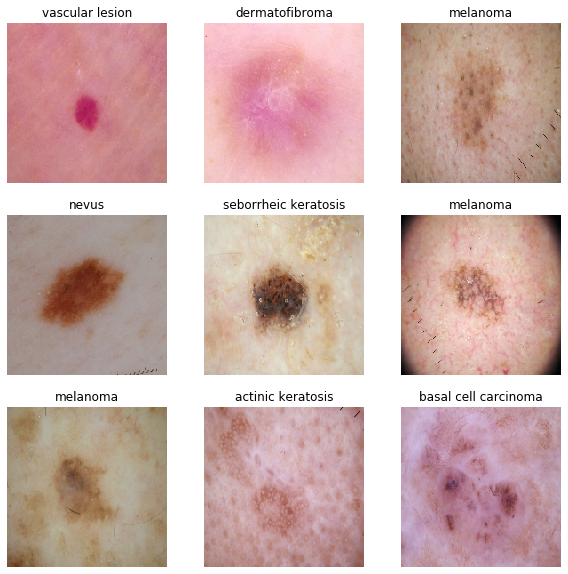

In [38]:
# visualize how your augmentation strategy works for one instance of training image.
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

### Create the model, compile and train the model

In [43]:
## You can use Dropout layer if there is an evidence of overfitting in your findings
input_shape = (180,180,3)

model = Sequential()
model.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180, 180, 3)))

# Increse the model size by adding another 32 layer
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(180,180,3)))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'))
# Max Pool size of 2*2
model.add(MaxPool2D(pool_size=(2, 2)))
# Adding Dropout Layer
model.add(Dropout(0.25))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding = 'Same'))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding = 'Same'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

model.add(Flatten())

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(9, activation='softmax'))

#model.summary()

In [44]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_5 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
module_wrapper_162 (ModuleWr (None, 180, 180, 32)      896       
_________________________________________________________________
module_wrapper_163 (ModuleWr (None, 180, 180, 32)      9248      
_________________________________________________________________
module_wrapper_164 (ModuleWr (None, 90, 90, 32)        0         
_________________________________________________________________
module_wrapper_165 (ModuleWr (None, 90, 90, 32)        0         
_________________________________________________________________
module_wrapper_166 (ModuleWr (None, 90, 90, 64)        18496     
_________________________________________________________________
module_wrapper_167 (ModuleWr (None, 90, 90, 64)      

### Compiling the model


In [45]:
optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

model.compile(loss='categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])

In order to make the optimizer converge faster and closest to the global minimum of the loss function, i used an annealing method of the learning rate (LR).

The LR is the step by which the optimizer walks through the 'loss landscape'. The higher LR, the bigger are the steps and the quicker is the convergence. However the sampling is very poor with an high LR and the optimizer could probably fall into a local minima.

In [46]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
    patience=3, 
    verbose=1, 
    factor=0.5, 
    min_lr=0.00001)


In [47]:
epochs = 20
batch_size = 10
history = model.fit(train_batches,
  epochs = epochs, verbose = 1, validation_data=valid_batches , callbacks=[learning_rate_reduction])

Epoch 1/20
14/14 [==============================] - 72s 5s/step - loss: 1.8252 - accuracy: 0.4270 - val_loss: 1.6029 - val_accuracy: 0.3333
Epoch 2/20
14/14 [==============================] - 69s 5s/step - loss: 1.0487 - accuracy: 0.4607 - val_loss: 1.4596 - val_accuracy: 0.3333
Epoch 3/20
14/14 [==============================] - 67s 5s/step - loss: 0.9844 - accuracy: 0.4798 - val_loss: 1.3241 - val_accuracy: 0.3333
Epoch 4/20
14/14 [==============================] - 66s 5s/step - loss: 0.9766 - accuracy: 0.4685 - val_loss: 1.3493 - val_accuracy: 0.2708

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 5/20
14/14 [==============================] - 66s 5s/step - loss: 0.9571 - accuracy: 0.4787 - val_loss: 1.3021 - val_accuracy: 0.3333
Epoch 6/20
14/14 [==============================] - 66s 5s/step - loss: 0.9318 - accuracy: 0.5169 - val_loss: 1.2997 - val_accuracy: 0.3125
Epoch 7/20
14/14 [==============================] - 66s 5s/step - loss: 0.9276 

### Visualizing the results

<built-in method keys of dict object at 0x7fab4031c360> :


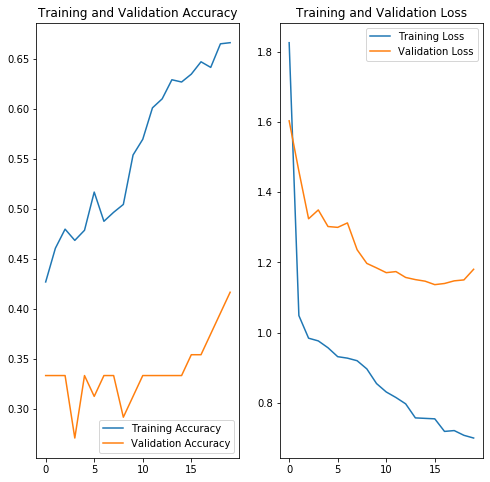

In [48]:
acc = history.history['accuracy']
print(history.history.keys, ":")
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

<Figure size 720x720 with 0 Axes>

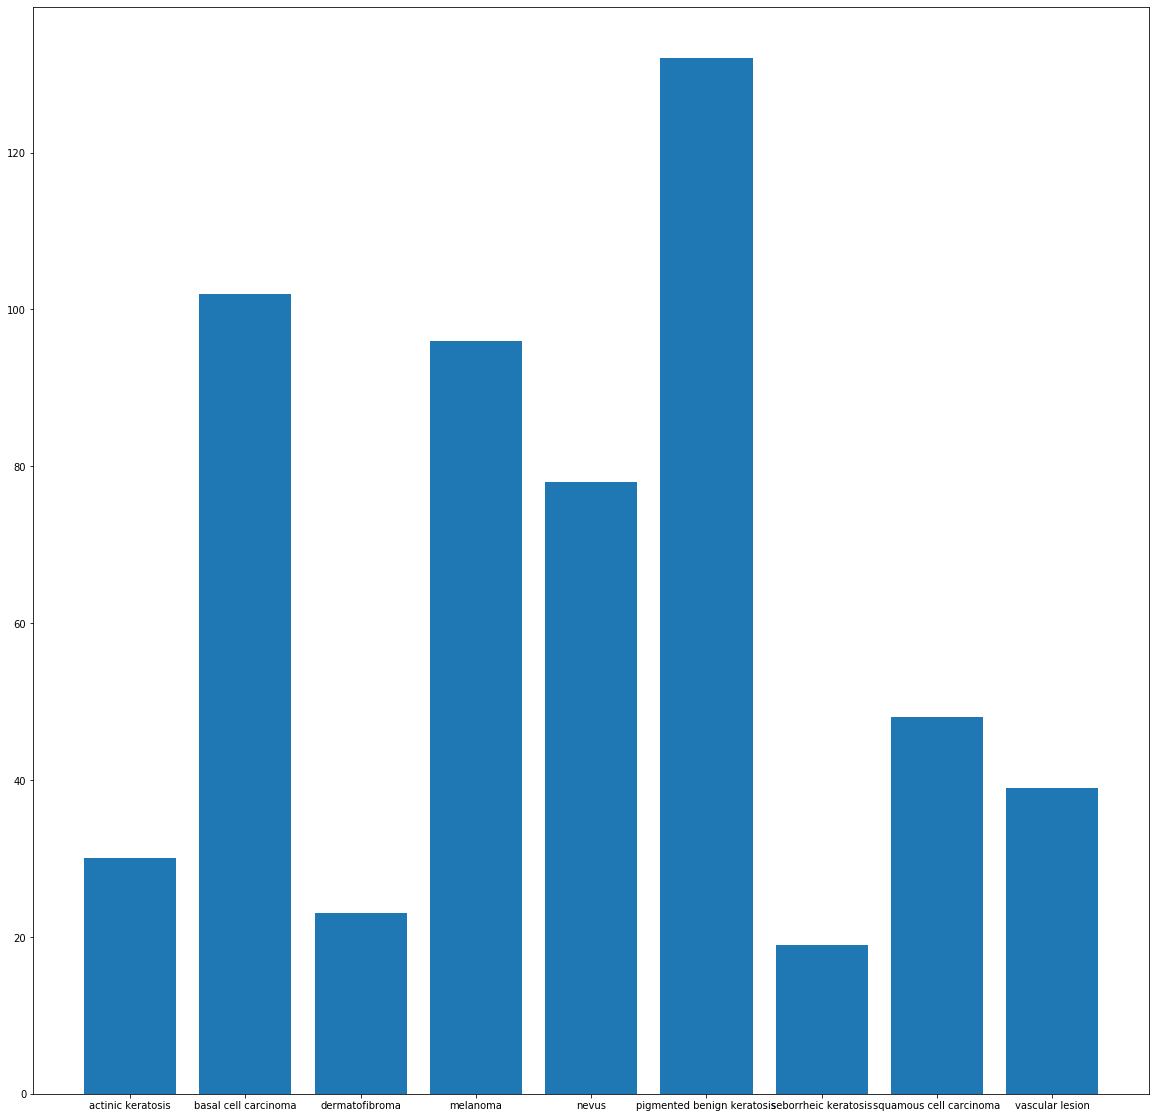

In [49]:
import matplotlib.pyplot as plt
data = dict()

for i in class_names:
    data[i] = []

plt.figure(figsize=(10, 10))
for images, labels in train_ds:
    for i in range(9):
        data[class_names[labels[i]]].append(images[i].numpy().astype("uint8"))

for i in data:
    model.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180, 180, 3)))
data[i] = len(data[i]) 

f = plt.figure()
f.set_figwidth(20)
f.set_figheight(20)

plt.bar(range(len(data)), list(data.values()), align='center')
plt.xticks(range(len(data)), list(data.keys()))
plt.show()


## Model 3

### Rectify the class imbalance


In [11]:
!pip install Augmentor

To use Augmentor, the following general procedure is followed:

Instantiate a Pipeline object pointing to a directory containing your initial image data set.
Define a number of operations to perform on this data set using your Pipeline object.
Execute these operations by calling the Pipeline’s sample() method.

In [15]:
path_to_training_dataset="Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
# data_dir_train = pathlib.Path(root_path + '/Train')
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) 

Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 114 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F9514C8F9E8>: 100%|██████████| 500/500 [00:04<00:00, 107.27 Samples/s]                 
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 376 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F9514C64780>: 100%|██████████| 500/500 [00:04<00:00, 107.57 Samples/s]                 
Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F9514BE7710>:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 95 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F95154EEA58>: 100%|██████████| 500/500 [00:04<00:00, 103.11 Samples/s]                 
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 438 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F9514C37828>: 100%|██████████| 500/500 [00:59<00:00,  8.36 Samples/s]                   
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 357 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F9514B57940>: 100%|██████████| 500/500 [00:32<00:00, 15.43 Samples/s]  
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 462 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F95154EEB70>: 100%|██████████| 500/500 [00:04<00:00, 107.00 Samples/s]                 
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 77 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7F9514BD7198>: 100%|██████████| 500/500 [00:09<00:00, 52.76 Samples/s]
Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F9514C7ED68>:   1%|          | 5/500 [00:00<01:09,  7.13 Samples/s]

Initialised with 181 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F9514C607B8>: 100%|██████████| 500/500 [00:04<00:00, 101.71 Samples/s]
Executing Pipeline:   0%|          | 0/500 [00:00<?, ? Samples/s]

Initialised with 139 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F951554C0B8>: 100%|██████████| 500/500 [00:04<00:00, 101.61 Samples/s]                 


In [16]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


In [18]:
from glob import glob
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['/home/rishabh/Documents/Diploma_notebook/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0027141.jpg_3c10b4a7-bd39-4fb7-96a4-df5c21591cec.jpg',
 '/home/rishabh/Documents/Diploma_notebook/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0031735.jpg_2fe9a821-4727-403f-964a-99ea8f07fa0e.jpg',
 '/home/rishabh/Documents/Diploma_notebook/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0028790.jpg_f0822ae8-259d-4337-8e23-92437a772178.jpg',
 '/home/rishabh/Documents/Diploma_notebook/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0029967.jpg_02252f94-3b0e-49f7-a190-8248b30dbb75.jpg',
 '/home/rishabh/Documents/Diploma_notebook/CNN_assignment/Skin cancer IS

In [19]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new


['dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofibroma',
 'dermatofib

In [20]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))


In [21]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = df2

In [22]:
new_df['Label'].value_counts()


nevus                         500
actinic keratosis             500
vascular lesion               500
basal cell carcinoma          500
pigmented benign keratosis    500
dermatofibroma                500
melanoma                      500
squamous cell carcinoma       500
seborrheic keratosis          500
Name: Label, dtype: int64

### Train the model on the data created using Augmentor

In [23]:
batch_size = 32
img_height = 180
img_width = 180

#### Create a training dataset


In [24]:
#data_dir_train="/content/gdrive/MyDrive/CNN/Skin_Data_Store/Train"
data_dir_train = ("/home/rishabh/Documents/Diploma_notebook/CNN_assignment/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.1,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 6066 files for training.


In [25]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.1,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 6739 files belonging to 9 classes.
Using 673 files for validation.


In [28]:
input_shape = (180,180,3)

model = Sequential()

# Increse the model size by adding another 32 layer
model.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(180, 180, 3)))

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=input_shape))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'))

# Max Pool size of 2*2
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(BatchNormalization())
# Adding Dropout Layer
model.add(Dropout(0.25))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding = 'Same'))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding = 'Same'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Dropout(0.4))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(1, activation='softmax'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 180, 180, 3)       0         
_________________________________________________________________
module_wrapper_15 (ModuleWra (None, 180, 180, 32)      896       
_________________________________________________________________
module_wrapper_16 (ModuleWra (None, 180, 180, 32)      9248      
_________________________________________________________________
module_wrapper_17 (ModuleWra (None, 90, 90, 32)        0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 90, 90, 32)        128       
_________________________________________________________________
module_wrapper_18 (ModuleWra (None, 90, 90, 32)        0         
_________________________________________________________________
module_wrapper_19 (ModuleWra (None, 90, 90, 64)       

### Compile your model (Choose optimizer and loss function appropriately)

In [29]:
optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

model.compile(loss='categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])

#### Train your model


In [ ]:
epochs = 50

learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
    patience=3, 
    verbose=1, 
    factor=0.5, 
    min_lr=0.00001)

batch_size = 10
history = model.fit(train_ds,
  epochs = epochs, verbose = 1, validation_data=val_ds , callbacks=[learning_rate_reduction])

Epoch 1/50
190/190 [==============================] - 490s 3s/step - loss: 0.0000e+00 - accuracy: 0.1307 - val_loss: 0.0000e+00 - val_accuracy: 0.1233
Epoch 2/50
190/190 [==============================] - 520s 3s/step - loss: 0.0000e+00 - accuracy: 0.1307 - val_loss: 0.0000e+00 - val_accuracy: 0.1233
Epoch 3/50
190/190 [==============================] - 505s 3s/step - loss: 0.0000e+00 - accuracy: 0.1307 - val_loss: 0.0000e+00 - val_accuracy: 0.1233
Epoch 4/50
190/190 [==============================] - 498s 3s/step - loss: 0.0000e+00 - accuracy: 0.1307 - val_loss: 0.0000e+00 - val_accuracy: 0.1233

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 5/50
190/190 [==============================] - 495s 3s/step - loss: 0.0000e+00 - accuracy: 0.1307 - val_loss: 0.0000e+00 - val_accuracy: 0.1233
Epoch 6/50
190/190 [==============================] - 447s 2s/step - loss: 0.0000e+00 - accuracy: 0.1307 - val_loss: 0.0000e+00 - val_accuracy: 0.1233
Epoch 7/50
19